**Make sure you have `tests.zip` in the directory with this Python notebook before running the following lines.**
In order to upload a `.zip` file to Google Colab, click the file folder icon (the one that looks like a folder) in the far-left pane. The left pane should now be titled "Files." Click the file icon with the up arrow. This should allow you to upload files from your local machine. Choose `tests.zip`, wherever it is downloaded.

In [ ]:
# Before running: make sure tests.zip is in the same directory as this notebook.
!pip install otter-grader
!unzip tests.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Archive:  tests.zip
replace tests/p1.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace tests/p4.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace tests/p3.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace tests/p2.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook(colab=True)

# Programming Assignment 2 for COMS 3251 Fall 2022

In [ ]:
import numpy as np

In [ ]:
# You are welcome to use this function in your solutions, but it is not required.
def REF(A):
    """
    input (np.ndarray): A matrix A, in the form of np.ndarray
    output (np.ndarray): The Row Echelon Form (REF) of A. NOTE: this is NOT RREF.
    """
    A = A.astype(float)
    pr = 0    # row with current pivot
    pc = 0    # col with current pivot

    while pr < A.shape[0] and pc < A.shape[1]:  # run until last row or last column
        nonzeros = np.nonzero(A[pr:,pc])[0]         # find nonzero entries in column
        if nonzeros.size == 0:                      # no nonzero entries, move to next column
            pc += 1

        else:
            row = nonzeros[0] + pr
            A[[pr, row]] = A[[row, pr]]             # swap rows with the found pivot
            scaled = np.outer(A[pr+1:,pc]/A[pr,pc], A[pr])
            A[pr+1:] -= scaled                      # row-reduce all rows below pivot
            pr += 1                                 # move to next pivot position
            pc += 1

    return A

In [ ]:
# You are welcome to use this function in your solutions, but it is not required.
def back_substitute(augmented_REF, pivot_vars):
    """
    input (np.ndarray): An augmented matrix [A|b] in REF, which is assumed to be consistent and pivot_vars, the indices of the pivot variables.
    output (np.ndarray): The (possibly non-unique) solution x to the system Ax = b.
    """
    # Solution vector (-1 because b is appended column)
    x = np.zeros(augmented_REF.shape[1] - 1)

    # Get R and c from augmented matrix, dropping all zero rows
    augmented_REF = augmented_REF[~np.all(np.isclose(augmented_REF, 0), axis=1)]
    # numpy.isclose: Returns a boolean array where two arrays are element-wise equal within a tolerance.
    # np.all: Test whether all array elements along a given axis evaluate to True.
    R = augmented_REF[:, :-1]
    c = augmented_REF[:, -1]

    # Drop free columns (these variables become 0)
    R = R[:, pivot_vars]
    assert(R.shape[0] == R.shape[1])
    rank = R.shape[0]
    x_pivots = np.zeros(rank)

    # Do back-substitution
    for row in range(rank-1, -1, -1):
        sol = c[row]
        for col in range(rank-1, row, -1):
            sol -= x_pivots[col] * R[row][col]

        if np.isclose(R[row][row], 0):
            x_pivots[row] = 0
        else:
            x_pivots[row] = sol/R[row][row]

    for i in range(len(x_pivots)):
        x[pivot_vars[i]] = x_pivots[i]
        
    return x

# Part 1: University rankings

## Problem statement

There are (currently) 8 Ivy League universities (Brown, Columbia, Cornell, Dartmouth, Harvard, Penn, Princeton, and Yale). Students were asked to compare 12 different pairs of Ivy League universities (e.g., Harvard vs Yale). For each of these 12 pairs $(a,b)$, we record the number $F_{a,b}$ of times that $a$ was compared favorably to $b$ (the statement "$a > b$" was chosen), and also the number $F_{b,a}$ of times that $b$ was compared favorably to $a$ (the statement "$b > a$" was chosen). (Note that students were only asked to compare 12 of the 28 possible pairs of universities.)

We hypothesize that each of the 8 Ivy League universities can be assigned some "quality score" $Q_a$ such that the "vote difference" $F_{b,a} - F_{a,b}$ is equal to the difference in quality scores $Q_b - Q_a$. (We refer to these desired equalities as the "vote difference constraints".) Such a quality score could be used to "rank" the universities. We would like to find such quality scores if they exist, or declare that no such quality scores exist.

## Setting up the data

In [ ]:
# list of universities
universities = ['Brown', 'Columbia', 'Cornell', 'Dartmouth', 'Harvard', 'Penn', 'Princeton', 'Yale']

In [ ]:
# the comparisons we sought in the survey
comparisons = [('Brown', 'Harvard'),
               ('Brown', 'Yale'),
               ('Columbia', 'Cornell'),
               ('Columbia', 'Penn'),
               ('Columbia', 'Princeton'),
               ('Columbia', 'Yale'),
               ('Cornell', 'Dartmouth'),
               ('Cornell', 'Penn'),
               ('Cornell', 'Princeton'),
               ('Dartmouth', 'Harvard'),
               ('Harvard', 'Yale'),
               ('Penn', 'Princeton')
              ]

In [ ]:
# download the survey results
!curl -o ivyleague.csv https://www.cs.columbia.edu/~djhsu/coms3251-f22/data/ivyleague.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25719  100 25719    0     0  95609      0 --:--:-- --:--:-- --:--:-- 95609


In [ ]:
# loads the data from the CSV file, compute the vote differences for all comparisons
from csv import DictReader
vote_differences = dict.fromkeys(comparisons, 0.)
with open('ivyleague.csv') as f:
    reader = DictReader(f)
    for row in reader:
        for (u,v) in comparisons:
            if row['{0} vs {1}'.format(u,v)] == '{0} > {1}'.format(u,v):
                vote_differences[(u,v)] -= 1
            else:
                vote_differences[(u,v)] += 1

comparisons_and_vote_differences = [
    ((universities.index(u), universities.index(v)), vote_differences[(u,v)])
    for (u,v) in comparisons
]

The first entry in the list `comparison_and_vote_difference` should show that in the comparison "Brown vs Harvard", Harvard was compared favorably to Brown 50 more times than Brown was compared favorably to Harvard.

The third entry in the list `comparison_and_vote_difference` should show that in the comparison "Columbia vs Cornell", Cornell was compared favorably to Columbia 70 *fewer* times than Columbia was compared favorably to Cornell.

In [ ]:
comparisons_and_vote_differences

[((0, 4), 50.0),
 ((0, 7), 50.0),
 ((1, 2), -70.0),
 ((1, 5), -62.0),
 ((1, 6), -16.0),
 ((1, 7), -24.0),
 ((2, 3), -28.0),
 ((2, 5), 8.0),
 ((2, 6), 54.0),
 ((3, 4), 74.0),
 ((4, 7), 0.0),
 ((5, 6), 46.0)]

## Problem 1: Finding Quality Scores

Implement the function `find_quality_scores`, described below.

The inputs to `find_quality_scores` are `N` and `L`; `N` is the number of objects being compared (such as `len(universities)` above); `L` is a list of "comparison and vote difference pairs" (such as `comparisons_and_vote_differences` above). A "comparison and vote difference pair" is a pair of the form `((i, j), d)`, where `(i, j)` is a pair of distinct indices, each between `0` and `n-1`; and `d` is a floating point number representing the difference between the number of times object `j` was compared favorably to object `i`, and the number of times object `i` was compared favorably to object `j`.

The output of `find_quality_scores` is a pair `(consistent, qualities)`, where `consistent` is a boolean value, and `qualities` is a 1D `numpy` array. If no quality scores exist to satisfy the vote difference constraints, then `consistent` should be `False` and `qualities` should just be returned as `None`. Otherwise, `consistent` should be `True`, and `qualities` should contain the quality scores that satisfy all vote difference constraints.

### Additional help with Problem 1
To implement `find_quality_scores`, you may find it enlightening to reread Section 2 on **Potential Differences** in `connectivity.pdf`. There are three main steps you need to take for this problem:

1. Form an incidence matrix, $A$, based on the comparisons. This is `form_incidence_matrix`.
2. Form a solution vector $\mathbf{b}$, based on potential differences. This is `form_sol_vector`.
3. Solve the system $A\mathbf{x} = \mathbf{b}$ for $\mathbf{x}$, the vector of potentials. There are multiple ways to implement this. In the way that uses the functions `REF` and `back_substitute` at the beginning of this notebook, it may be helpful to refer back to **Theorem 1** of `elimination.pdf`, focus on finding pivot variables and free variables, and then performing back-substitution. This is `solve_system_REF`. 

**NOTE:** If you decide to go this route, please note that `back_substitute` assumes that the system $[R|\mathbf{c}]$ provided to it is consistent, i.e. we are in Case 2 or 3 of **Theorem 1** in `elimination.pdf`.

We provide three (ungraded, unimplemented) functions for you to separate this process out. You can then implement and use these three functions in `find_quality_scores` as building blocks to return the final solution `(consistent, qualities)`. This is not, necessary, however -- you are welcome to implement `find_quality_scores` in whatever way you see fit, as long as it can pass all the test cases.

In [ ]:
def form_incidence_matrix(N: int, L: list) -> np.ndarray:
    """
    Return the incidence matrix formed by the comparisons in L.
    """
    A = [[0]*N for _ in range(len(L))] # initialize A

    for i in range(len(L)):
      item = L[i]
      pair = item[0]
      A[i][pair[0]] = -1
      A[i][pair[1]] = 1
    return np.array(A)

# N = 5
# L = [((0,1), 1.0), ((1,2), 1.0), ((2,0), -2.0), ((3, 4), 3.0)]
# A = form_incidence_matrix(N,L)
# A

N = 3
L = [((0,1), 2), ((1,2), 4), ((2,0), 6)]
A = form_incidence_matrix(N,L)
A

array([[-1,  1,  0],
       [ 0, -1,  1],
       [ 1,  0, -1]])

In [ ]:
def form_sol_vector(L: list) -> np.ndarray:
    """
    Return the solution vector, b, formed by the comparison values in L.
    """
    b = [0]*(len(L))
    for i in range(len(L)):
      value = L[i][1]
      b[i] = value
    return np.array(b)

b = form_sol_vector(L)
b

array([2, 4, 6])

In [ ]:
def solve_system_REF(A: np.ndarray, b: np.ndarray) -> tuple:
    """
    Returns (True, x) if the system is consistent, where x is the solution to Ax = b.
    Returns (False, None) if the system Ax = b is inconsistent.
    """
    B = np.reshape(b.T, (A.shape[0],1))
    augmented = np.hstack((A, B))
    augmented_REF = REF(augmented)
    # print(REF(augmented))
    pivots = []
    ctr = 0
    for i in range(augmented_REF[:,:-1].shape[0]):
      for j in range(augmented_REF[:,:-1].shape[1]):
        if(augmented_REF[:,:-1][i][j]!=0):
          pivots.append(j)
          break
    # print(pivots)
    try:
      x = back_substitute(augmented_REF, pivots)
    except:
      return (False, None)
    else:
      return (True, x)

solve_system_REF(A, b)

(False, None)

In [ ]:
def find_quality_scores(N: int, L: list) -> tuple:
    """
    Implement the function `find_quality_scores` as described above.
    """
    A = form_incidence_matrix(N, L)
    b = form_sol_vector(L)
    consistent, qualities = solve_system_REF(A, b)
    if(consistent==True):
      return (True, qualities)
    else:
      return (False, None)

In [ ]:
grader.check("p1")

p1 results: All test cases passed!

### Find the quality scores for universities
We test out using `find_quality_scores` to find the quality scores for our 8 universities. For our specific set of data, `ivyleague.csv`, there should exist quality scores for the universities that satisfies our vote difference constraints, i.e. `consistent` should be `True`.

In [ ]:
(consistent, qualities) = find_quality_scores(len(universities), comparisons_and_vote_differences)
print(consistent)

True


In [ ]:
print("\n".join("{0}\t{1}".format(q, u) for q, u in zip(qualities - qualities.mean(), universities)))

-28.0	Brown
46.0	Columbia
-24.0	Cornell
-52.0	Dartmouth
22.0	Harvard
-16.0	Penn
30.0	Princeton
22.0	Yale


You should find that Columbia has the highest quality score among all universities in the Ivy Leage. Who would've thought?

## Problem 2

Implement the function `check_quality_scores`, described below.

The inputs to `check_quality_scores` are `N`, `L`, and `Q`. `N` is the number of objects being compared (such as `len(universities)` above). `L` is a list of "comparison and vote difference pairs" (such as `comparisons_and_vote_differences` above). A "comparison and vote difference pair" is a pair of the form `((i, j), d)`, where `(i, j)` is a pair of distinct indices, each between `0` and `n-1`; and `d` is a floating point number representing the difference between the number of times object `j` was compared favorably to object `i`, and the number of times object `i` was compared favorably to object `j`. And `Q` is a 1D `numpy` array of `N` quality scores.

The output of `check_quality_scores` is a boolean value `valid`, which is `True` if the quality scores in `Q` satisfy all vote difference constraints, and `False` otherwise.

In [ ]:
def check_quality_scores(N: int, L: list, Q: np.ndarray) -> bool:
    """
    Implement the function `check_quality_scores` as described above.
    """
    consistent, qualities = find_quality_scores(N,L)

    if(consistent == False):
      return False

    diff = Q-qualities
    for i in range(len(diff)-1):
      if(diff[i]!=diff[i+1]):
        return False

    return True

In [ ]:
grader.check("p2")

p2 results: All test cases passed!

In [ ]:
(consistent, qualities) = find_quality_scores(len(universities), comparisons_and_vote_differences)
print(check_quality_scores(len(universities), comparisons_and_vote_differences, qualities))
print(check_quality_scores(len(universities), comparisons_and_vote_differences, qualities + 42 * np.ones(len(universities))))

True
True


You should find that even if we add the same quality value to all quality scores, all vote difference constraints remain satisfied.

## Controversy in Morningside Heights

Oops! It turns out the ballot box was stuffed, and only the first 76 ballots were legitimate. How could such a thing happen?

In any case, let us recompute the vote differences and re-run `find_quality_scores`.

In [ ]:
vote_differences = dict.fromkeys(comparisons, 0.)
with open('ivyleague.csv') as f:
    reader = DictReader(f)
    count = 0
    for row in reader:
        if count >= 76:
            break
        else:
            count += 1
        for (u,v) in comparisons:
            if row['{0} vs {1}'.format(u,v)] == '{0} > {1}'.format(u,v):
                vote_differences[(u,v)] -= 1
            else:
                vote_differences[(u,v)] += 1

correct_comparisons_and_vote_differences = [
    ((universities.index(u), universities.index(v)), vote_differences[(u,v)])
    for (u,v) in comparisons
]

In [ ]:
correct_comparisons_and_vote_differences

[((0, 4), 50.0),
 ((0, 7), 50.0),
 ((1, 2), -70.0),
 ((1, 5), -66.0),
 ((1, 6), -12.0),
 ((1, 7), -24.0),
 ((2, 3), -28.0),
 ((2, 5), 20.0),
 ((2, 6), 54.0),
 ((3, 4), 70.0),
 ((4, 7), -46.0),
 ((5, 6), 46.0)]

In [ ]:
(consistent, qualities) = find_quality_scores(len(universities), correct_comparisons_and_vote_differences)
print(consistent)

False


You should find that the no quality scores can satisfy all vote difference constraints.

(Later in the course, we'll find a way to deal with such inconsistent systems of linear equations, using the method of least squares.)

# Part 2: Learning polynomial functions from data

## Problem statement

"Learning" is a complex phenomenon that appears to occur in nature, and it has been studied by scientists across many different disciplines. One form of learning is called "Occam Learning"; this is the computational task of finding a "simple" function that "fits" a data set of input-output pairs.

We will restrict attention to functions given by polynomials over a single variable with real coefficients, and datasets that contain $m$ pairs of real numbers $(x_1,y_1), (x_2,y_2), \dotsc, (x_m,y_m)$. In this setting, each example point in the dataset is an input-output pair from some underlying polynomial function $p$. We say that the polynomial $p$ "fits" the dataset if every input-output pair in the dataset satisfies the polynomial. That is, there exists some degree-$d$ polynomial $p$ such that

$$p(x_i) = a_0 + a_1x_i + a_2x_i^2 + \cdots + a_dx_i^d = y_i, \text{ for all } i \in \{1,\dotsc,m\}.$$

Recall (from `bases.pdf`) that $\mathsf{P}_d(\mathbb{R})$ denotes the set of all polynomials with degree *at most* $d$. If $p \in \mathsf{P}_d(\mathbb{R})$, then $p \in \mathsf{P}_{d+k}(\mathbb{R})$ for all $k \in \mathbb{N}$ as well. Hence, it makes sense to ask: *for a dataset of $m$ pairs of real numbers $(x_1, y_1), (x_2, y_2) \dotsc, (x_m, y_m)$, what is the polynomial of lowest degree that perfectly fits all examples?*

## Matrix-Vector Notation for Learning Polynomials
It turns out that we can actually solve this problem using linear algebra. We know that, given a polynomial of degree $d$, there are exactly $d + 1$ numbers that completely characterize it: the coefficients, $a_0, a_1, a_2, \dotsc, a_d$. If we have $a_0, a_1, a_2, \dotsc, a_d$, then we know the polynomial. Thus, "finding" a polynomial that fits a specific input-output pair $(x_i, y_i)$ amounts to finding $d + 1$ unknowns $a_0, a_1, a_2, \dotsc, a_d$ such that:

$$a_0 + a_1x_i + a_2x_i^2 + \cdots + a_dx_i^d = y_i.$$

If we look closely enough at this, we can rewrite this as a product between a $1 \times (d+1)$ matrix and a $(d+1) \times 1$ vector (this is a "dot product," a term that will be introduced formally in a later lecture).

$$\begin{bmatrix} 1 & x_i & x_i^2 & \dots & x_i^d \end{bmatrix} \begin{bmatrix} a_0 \\ a_1 \\ \vdots \\ a_d \end{bmatrix}  = a_0 + a_1x_i + a_2x_i^2 + \cdots + a_dx_i^d = y_i.$$

But our dataset has more than just one input-output pair. To ensure that our polynomial fits all the data, we can create a *design matrix* of shape $m \times {d+1}$ by iterating the above product $m$ times. This immediately gives us a system of linear equations to solve for $d + 1$ unknowns, which we'll denote $X\mathbf{a} = \mathbf{y}$:

$$\begin{bmatrix} 
1 & x_1 & x_1^2 & \dots & x_1^d \\
1 & x_2 & x_2^2 & \dots & x_2^d \\
1 & x_3 & x_3^2 & \dots & x_3^d \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_m & x_m^2 & \dots & x_m^d
\end{bmatrix}
\begin{bmatrix} a_0 \\ a_1 \\ a_2 \\ \vdots \\ a_d \end{bmatrix}
=
\begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ \vdots \\ y_m \end{bmatrix}.
$$

Solving this system for $\mathbf{a} = (a_0,a_1,\dotsc,a_d)$ means that there exists a polynomial of degree at most $d$ that fits all of the data. Showing that the system is inconsistent amounts to showing that there does not exist *any* polynomial of degree $d$ that fits the data. We can setup this system in the obvious way (changing the number of columns and unknowns) for other values of $d$.

## Problem 3
Implement the function `generate_design_mat`, described below.

The input to `generate_design_mat` are `X` and `d`. `X` is an `numpy` array of $m$ real numbers, representing the inputs for each input-output pair in the dataset. `d` is an `int` representing the degree of the desired polynomial that will be solved for with this design matrix.

The output to `generate_design_mat` is `design_X`, a `numpy` array of shape `(m, d+1)`. This is the design matrix in the system $X\mathbf{a} = \mathbf{y}$, stated above.

In [ ]:
def generate_design_mat(X: np.ndarray, d:int) -> np.ndarray:
    """
    Implements the function `generate_design_mat`, described above.
    """
    design_X = np.zeros(shape=(X.shape[0], d+1))
    for num in range(X.shape[0]):
      # print("num is " + str(num))
      for order in range(d+1):
        # print("order is " + str(order))
        design_X[num][order] = pow(X[num], order)
    
    return design_X

In [ ]:
grader.check("p3")

p3 results: All test cases passed!

## Problem 4
Implement the function `find_lowest_deg_poly`, described below. You may (and should) use the previous function `generate_design_mat` from **Problem 3** in your implementation. It may also be helpful to reuse code from **Part 1** of this notebook for solving systems of linear equations and `REF` in this function. In particular, if you implemented `solve_system_REF` above, then you may reuse it.

The inputs to `find_lowest_deg_poly` are `X` and `Y`. `X` is a `numpy` array of length `m` containing the inputs for the dataset, and `Y` is a `numpy` array of length `m` containing the outputs. These are guaranteed to be the input-output pairs for *some* polynomial.

The output to `find_lowest_deg_poly` is a pair `(d, a)`. `d` is the lowest degree of a polynomial that fits all of the data. `a` is a `numpy` array of shape `(d+1,)` and length `d + 1` containing the coefficients of the degree `d` polynomial, in the order $a_0, a_1, \dots, a_d$.

In [ ]:
def find_lowest_deg_poly(X: np.ndarray, Y: np.ndarray) -> tuple:
    d=0
    while(True):
      mat = generate_design_mat(X, d)
      consistent, solution = solve_system_REF(mat,Y)
      if(consistent):
        a = solution
        break
      else:
        d += 1
        continue
    return (d, a)

In [ ]:
grader.check("p4")

p4 results: All test cases passed!

We can attempt to visualize what's going on here with `matplotlib`. In the examples below, we generate a small dataset of `m = 20` points from some ground-truth polynomial and then run your function to find the lowest degree polynomial that fits the data. We then use `np.linspace` and the coefficients of the found polynomial to visualize the entire curve of the polynomial. Notice that the polynomial perfectly hits all the datapoints.

In [ ]:
import matplotlib.pyplot as plt
m = 20

In [ ]:
def coef_to_poly(a:np.ndarray, X:np.ndarray):
    Y = np.zeros_like(X)
    for deg in range(len(a)):
        Y += a[deg] * np.power(X, deg)
    return Y

First, we plot the simple degree-1 polynomial,
$$p(x) = x + 5,$$
which just happens to be a line.

Lowest Degree = 1


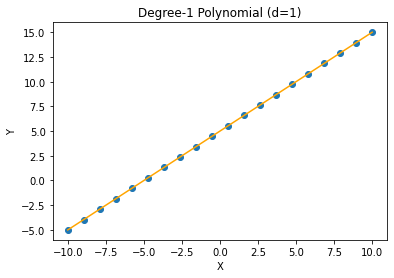

In [ ]:
# Degree-1 Polynomial (d = 1)
def p_1(X:np.ndarray):
    return X + 5

# Plot just the m points
X = np.linspace(-10, 10, num=m)
Y = p_1(X)
plt.title("Degree-1 Polynomial (d=1)")
plt.xlabel("X")
plt.ylabel("Y")

# Find the coefficients of the polynomial
d, a = find_lowest_deg_poly(X, Y)
X_poly = np.linspace(-10, 10)
Y_poly = coef_to_poly(a, X_poly)
plt.scatter(X, Y)
plt.plot(X_poly, Y_poly, color="orange")

print("Lowest Degree = {}".format(d))

Then, consider a degree-2 (quadratic) polynomial:
$$p(x) = x^2 + 2x - 3.$$

Lowest Degree = 12


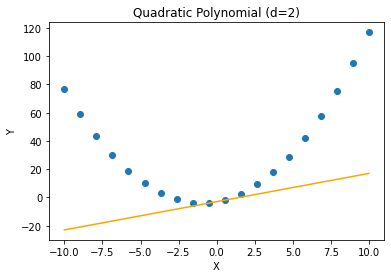

In [ ]:
# Quadratic Polynomial (d = 2)
def p_2(X:np.ndarray):
    return np.power(X, 2) + 2 * X - 3

# Plot just the m points
X = np.linspace(-10, 10, num=m)
Y = p_2(X)
plt.title("Quadratic Polynomial (d=2)")
plt.xlabel("X")
plt.ylabel("Y")

# Find the coefficients of the polynomial
d, a = find_lowest_deg_poly(X, Y)
X_poly = np.linspace(-10, 10)
Y_poly = coef_to_poly(a, X_poly)
plt.scatter(X, Y)
plt.plot(X_poly, Y_poly, color="orange")

print("Lowest Degree = {}".format(d))

And a degree-3 (cubic) polynomial:
$$p(x) = x^3 - x^2 + 2x + 1.$$

Lowest Degree = 2


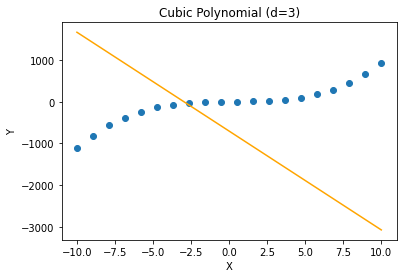

In [ ]:
# Cubic Polynomial (d = 3)
def p_3(X:np.ndarray):
    return np.power(X, 3) - np.power(X, 2) + 2 * X + 1

# Plot just the m points
X = np.linspace(-10, 10, num=m)
Y = p_3(X)
plt.title("Cubic Polynomial (d=3)")
plt.xlabel("X")
plt.ylabel("Y")

# Find the coefficients of the polynomial
d, a = find_lowest_deg_poly(X, Y)
X_poly = np.linspace(-10, 10)
Y_poly = coef_to_poly(a, X_poly)
plt.scatter(X, Y)
plt.plot(X_poly, Y_poly, color="orange")

print("Lowest Degree = {}".format(d))

We're even able to learn the exact degree-6 polynomial,
$$p(x) = x^6 - 4x^5 + x^2 + x + 2,$$
which has a huge range in $y$ values.

Lowest Degree = 2


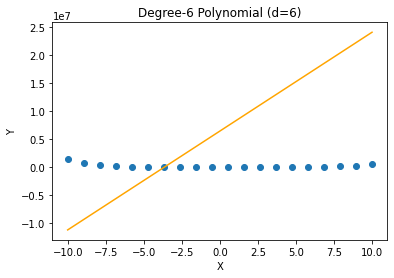

In [ ]:
# Degree-6 Polynomial (d = 6)
def p_6(X:np.ndarray):
    return np.power(X, 6) - 4 * np.power(X, 5) + np.power(X, 2) + X + 2

# Plot just the m points
X = np.linspace(-10, 10, num=m)
Y = p_6(X)
plt.title("Degree-6 Polynomial (d=6)")
plt.xlabel("X")
plt.ylabel("Y")

# Find the coefficients of the polynomial
d, a = find_lowest_deg_poly(X, Y)
X_poly = np.linspace(-10, 10)
Y_poly = coef_to_poly(a, X_poly)
plt.scatter(X, Y)
plt.plot(X_poly, Y_poly, color="orange")

print("Lowest Degree = {}".format(d))

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()

p1 results: All test cases passed!

p2 results: All test cases passed!

p3 results: All test cases passed!

p4 results: All test cases passed!